In [1]:
from __future__ import print_function

import os
import sys
import time
import argparse
import datetime
import math
import pickle


import torchvision
import torchvision.transforms as transforms
from utils.autoaugment import CIFAR10Policy

import torch
import torch.utils.data as data
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
from utils.BBBlayers import GaussianVariationalInference
from utils.BayesianModels.Bayesian3Conv3FC import BBB3Conv3FC
from utils.BayesianModels.BayesianAlexNet import BBBAlexNet
from utils.BayesianModels.BayesianLeNet import BBBLeNet
from utils.BayesianModels.BayesianSqueezeNet import BBBSqueezeNet

In [3]:
net_type = 'alexnet'
dataset = 'CIFAR10'
outputs = 10
inputs = 3
resume = False
n_epochs = 20
lr = 0.001
weight_decay = 0.0005
num_samples = 10
beta_type = "Blundell"
resize=32

In [4]:
# Hyper Parameter settings
use_cuda = torch.cuda.is_available()
torch.cuda.set_device(0)

In [5]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64
# percentage of training set to use as validation
valid_size = 0.2

In [6]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [8]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [9]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [10]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

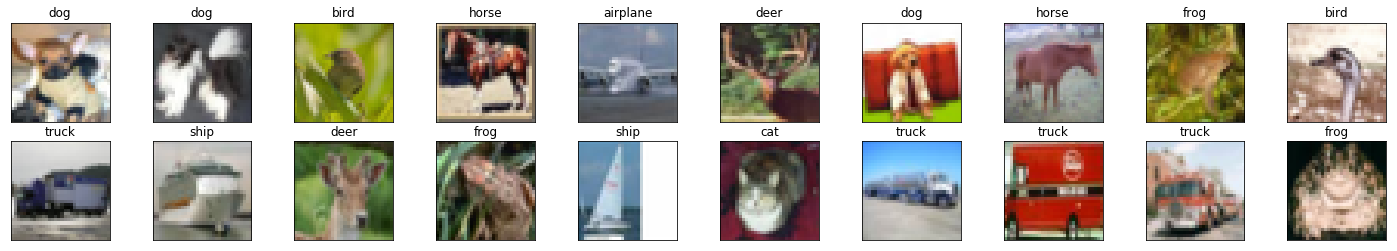

In [12]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

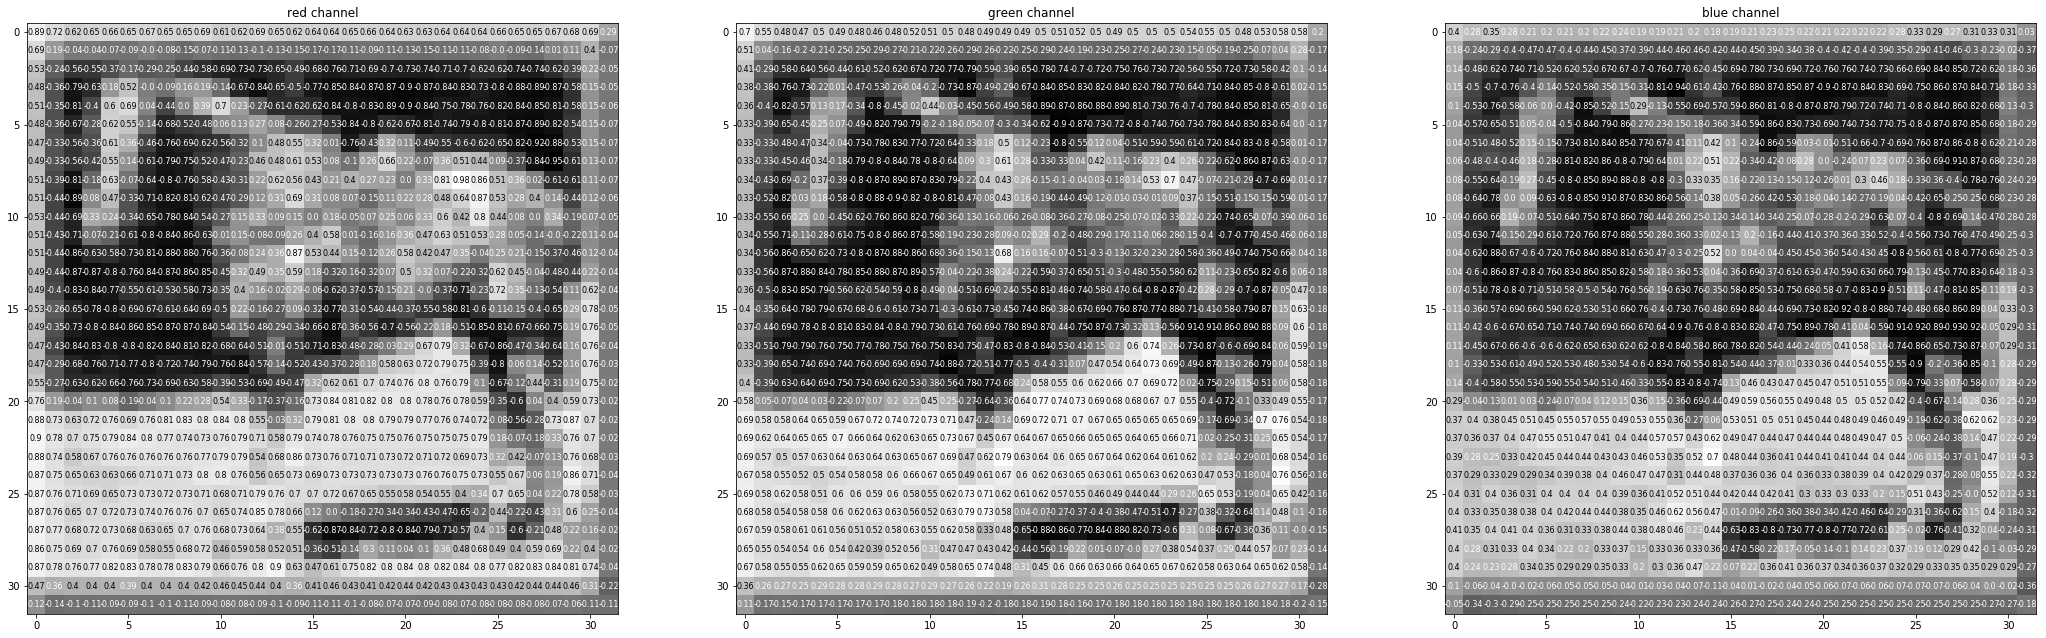

In [13]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

In [14]:
# Architecture
if (net_type == 'lenet'):
    net = BBBLeNet(outputs,inputs)
elif (net_type == 'alexnet'):
    net = BBBAlexNet(outputs,inputs)
elif (net_type == '3conv3fc'):
        net = BBB3Conv3FC(outputs,inputs)
else:
    print('Error : Network should be either [LeNet / AlexNet / 3Conv3FC')


In [15]:
if use_cuda:
    net.cuda()

In [16]:
vi = GaussianVariationalInference(torch.nn.CrossEntropyLoss())
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

In [17]:
ckpt_name = f'model_{net_type}_{dataset}_frequentist.pt'
ckpt_name

'model_alexnet_CIFAR10_frequentist.pt'

In [18]:
%%time

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    m = math.ceil(len(train_data) / batch_size)
    
    ###################
    # train the model #
    ###################
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        
        data = data.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
        target = target.repeat(num_samples)
        if use_cuda:
            data, target = data.cuda(), target.cuda()
            
        if beta_type is "Blundell":
            beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
        elif beta_type is "Soenderby":
            beta = min(epoch / (num_epochs // 4), 1)
        elif beta_type is "Standard":
            beta = 1 / m
        else:
            beta = 0
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output,kl = net.probforward(data)
        # calculate the batch loss
        loss = vi(output, target, kl, beta)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    net.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        data = data.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
        target = target.repeat(num_samples)
        # move tensors to GPU if CUDA is available
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output,kl = net.probforward(data)
        # calculate the batch loss
        loss = vi(output, target, kl, beta)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(net.state_dict(), ckpt_name)
        valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 15895.008191 	Validation Loss: 4.429152
Validation loss decreased (inf --> 4.429152).  Saving model ...
Epoch: 2 	Training Loss: 14452.848774 	Validation Loss: 4.145948
Validation loss decreased (4.429152 --> 4.145948).  Saving model ...
Epoch: 3 	Training Loss: 12592.072716 	Validation Loss: 3.954385
Validation loss decreased (4.145948 --> 3.954385).  Saving model ...
Epoch: 4 	Training Loss: 10756.279944 	Validation Loss: 3.540767
Validation loss decreased (3.954385 --> 3.540767).  Saving model ...
Epoch: 5 	Training Loss: 8992.009638 	Validation Loss: 3.029844
Validation loss decreased (3.540767 --> 3.029844).  Saving model ...
Epoch: 6 	Training Loss: 7333.118185 	Validation Loss: 2.931043
Validation loss decreased (3.029844 --> 2.931043).  Saving model ...
Epoch: 7 	Training Loss: 5806.978550 	Validation Loss: 2.717810
Validation loss decreased (2.931043 --> 2.717810).  Saving model ...
Epoch: 8 	Training Loss: 4451.747157 	Validation Loss: 2.657072
Valida

In [19]:
net.load_state_dict(torch.load(ckpt_name))

In [20]:
%%time

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

net.eval()
m = math.ceil(len(test_data) / batch_size)
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    
    data = data.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
    target = target.repeat(num_samples)
    # move tensors to GPU if CUDA is available
    if use_cuda:
        data, target = data.cuda(), target.cuda()
    
    if beta_type is "Blundell":
        beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
    elif cf.beta_type is "Soenderby":
        beta = min(epoch / (cf.num_epochs // 4), 1)
    elif cf.beta_type is "Standard":
        beta = 1 / m
    else:
        beta = 0
    # forward pass: compute predicted outputs by passing inputs to the model
    output, kl = net.probforward(data)
    # calculate the batch loss
    loss = vi(output, target, kl, beta)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not use_cuda else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        if i >= target.data.shape[0]: # batch_size could be greater than left number of images
            break
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 9519.057313

Test Accuracy of airplane: 62% (629/1006)
Test Accuracy of automobile: 74% (746/1003)
Test Accuracy of  bird: 39% (396/1003)
Test Accuracy of   cat: 38% (391/1009)
Test Accuracy of  deer: 57% (578/1000)
Test Accuracy of   dog: 62% (628/1009)
Test Accuracy of  frog: 71% (714/1000)
Test Accuracy of horse: 70% (714/1009)
Test Accuracy of  ship: 77% (785/1009)
Test Accuracy of truck: 64% (648/1000)

Test Accuracy (Overall): 61% (6229/10048)
CPU times: user 2.86 s, sys: 383 ms, total: 3.24 s
Wall time: 3.24 s


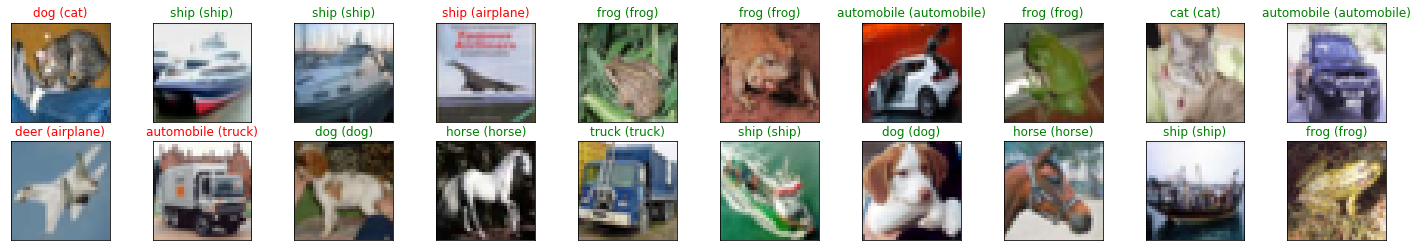

In [21]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if use_cuda:
    images = images.cuda()

# get sample outputs
output, kl = net.probforward(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))